## simulation test

In [462]:
%reload_ext autoreload
%autoreload 2

In [463]:
from neural_plot_ult import *

## 1120 quick test
does encoding residual have dynamic?
let the true dynamic be x t+1 = A x + B O
let the neural dynamic be x t+1 = C x + D O + n.

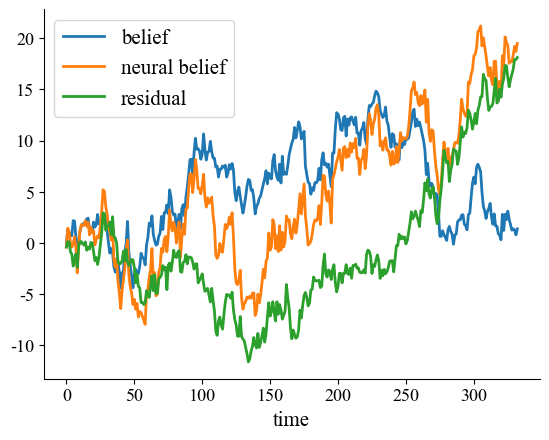

In [491]:
totaltime=100
triallen=333

# dynamic system of x dot  = Ax + Bu
A=1.0
B=dt=1
# neural
Ahat=2
Bhat=2
# generate neural white noise
rnoise=np.random.normal(0,1,size=(totaltime*triallen,))*1

# generate noisy input u.
# us=np.random.normal(0,1,size=(totaltime*triallen,))
rho = 0.9      # desired correlation coefficient
# Generate correlated Gaussian variables
mean = [0, 0]  # Mean of both `us` and `vs`
cov = [[1, rho], [rho, 1]]  # Covariance matrix with `rho` as the correlation
# Generate the bivariate normal samples
samples = np.random.multivariate_normal(mean, cov, size=(totaltime * triallen,))
us = samples[:, 0]  # First variable
vs = samples[:, 1]  # Second variable, correlated with `us`

def transition(x,u):
    # x, state. u. noisy input
    return A*x+B*u
def rtransition(x,u):
    return Ahat*x+Bhat*u

# run the system
xs=[]
rs=[]
for i in range(totaltime):
    x=x0=0#np.random.rand(1)
    r0=r=x0
    for t in range(triallen):
        x=transition(x,us[t+i*triallen])
        xs.append(x)

        r=transition(r,us[t+i*triallen])+rnoise[t]
        rs.append(r)

xs=np.array(xs).reshape(-1)
rs=np.array(rs)
plt.plot(xs[:333], label='belief')
plt.plot(rs[:333], label='neural belief')
plt.plot(rs[:333]-xs[:333], label='residual')

plt.xlabel('time')
plt.legend()


## working

### the system:
systme is x dot  = Ax + Bu + noise in standard case. however, in our case, the system does not have system noise, but have noisy control.
so x dot = Ax + Bu where u is noisy. (white noise)
### neural encoding of the system:
neural activity encodes the system. we have function underlying the above system.
x hat dot  = A xhat + Bu + noise.
here we think the u is the same, thats the observation they actually recieved. but we do not know the u exactly.

In [449]:
totaltime=100
triallen=100

# dynamic system of x dot  = Ax + Bu
A=1.0
B=dt=1
# neural
Ahat=A
Bhat=dt=0.1
# generate neural white noise
rnoise=np.random.normal(0,1,size=(totaltime*triallen,))*2

# generate noisy input u.
# us=np.random.normal(0,1,size=(totaltime*triallen,))
rho = 0.9      # desired correlation coefficient
# Generate correlated Gaussian variables
mean = [0, 0]  # Mean of both `us` and `vs`
cov = [[1, rho], [rho, 1]]  # Covariance matrix with `rho` as the correlation
# Generate the bivariate normal samples
samples = np.random.multivariate_normal(mean, cov, size=(totaltime * triallen,))
us = samples[:, 0]  # First variable
vs = samples[:, 1]  # Second variable, correlated with `us`


def transition(x,u):
    # x, state. u. noisy input
    return A*x+B*u
def rtransition(x,u):
    return Ahat*x+Bhat*u

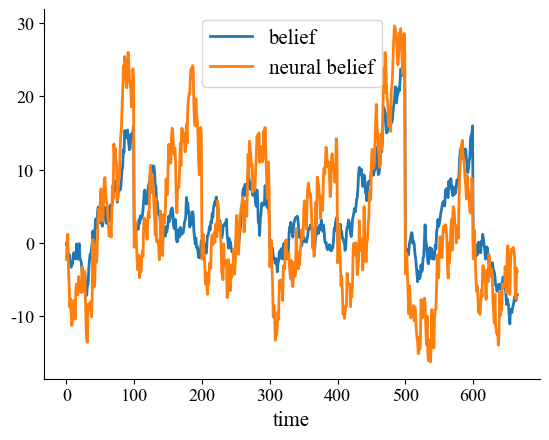

In [450]:
# run the system
xs=[]
rs=[]
for i in range(totaltime):
    x=x0=0#np.random.rand(1)
    r0=r=x0
    for t in range(triallen):
        x=transition(x,us[t+i*triallen])
        xs.append(x)

        r=transition(r,vs[t+i*triallen])+rnoise[t]
        rs.append(r)

xs=np.array(xs).reshape(-1)
rs=np.array(rs)
plt.plot(xs[:666], label='belief')
plt.plot(rs[:666], label='neural belief')
plt.xlabel('time')
plt.legend()


In [451]:
def myscatter(thisx, thisy):
    fig, ax = plt.subplots()  
    ax.scatter(thisx, thisy, s=1)
    slope = plot_best_fit(thisx, thisy, ax)
    r, _ = pearsonr(thisx, thisy)
    ax.set_title(f'slope: {slope:.2f}, Pearson r: {r:.2f}')
    return fig, ax

Text(0.5, 1.0, 'encoding\nslope: 1.00, Pearson r: 0.63 \n encoding var explained 0.40')

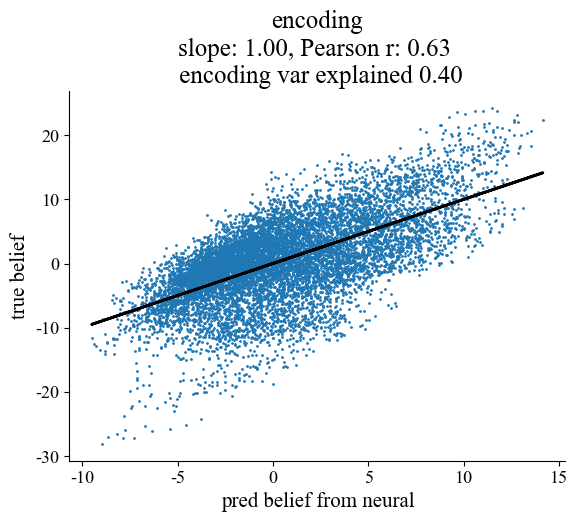

In [452]:
# encoding:
encode = LinearRegression()
encode.fit(np.array(rs).reshape(-1,1), np.array(xs).reshape(-1,1))
xs_hat=cross_val_predict(encode, np.array(rs).reshape(-1,1), np.array(xs).reshape(-1,1))
xs_hat=xs_hat.reshape(-1)


totalvar=np.var(xs)
encoding_residual_var=np.sum(np.array([(p-t)**2 for p, t in zip(xs_hat,xs)]))/totaltime
encoding_var_explained=totalvar-encoding_residual_var
totalvar,encoding_residual_var,encoding_var_explained, encoding_var_explained/totalvar,explained_variance_score(xs, xs_hat)


plt.scatter(xs_hat, xs,s=1)
plt.xlabel('pred belief from neural')
plt.ylabel('true belief')
ax=plt.gca()
slope=plot_best_fit(xs_hat, xs, ax)
r,_=pearsonr(xs_hat, xs,)
ax.set_title(f'encoding\nslope: {slope:.2f}, Pearson r: {r:.2f} \n encoding var explained {explained_variance_score(xs, xs_hat):.2f}')

In [453]:
# recoding, updates
# dxs=np.diff(xs)
# dxs_hat=np.diff(xs_hat)

dxs=[]
for i in range(totaltime):
    trialxs=xs[i*triallen:(i+1)*triallen]
    dxs.append(np.diff(trialxs,prepend=0))
dxs=np.concatenate(dxs)

dxs_hat=[]
for i in range(totaltime):
    trialxs=xs_hat[i*triallen:(i+1)*triallen]
    dxs_hat.append(np.diff(trialxs,prepend=0))
dxs_hat=np.concatenate(dxs_hat)

os=[]
for i in range(totaltime):
    trialxs=us[i*triallen:(i+1)*triallen]
    os.append(np.diff(trialxs,prepend=0))
os=np.concatenate(os)

drs=[]
for i in range(totaltime):
    trialxs=rs[i*triallen:(i+1)*triallen]
    drs.append(np.diff(trialxs,prepend=0))
drs=np.concatenate(drs)

# drs=np.diff(rs.reshape(-1), prepend=0)
# dxs_hat_pred=encode.predict(drs.reshape(-1,1)).reshape(-1)


(-4.489307786625295, 3.7357130512018113, -3.266144148744817, 4.092833538540376)

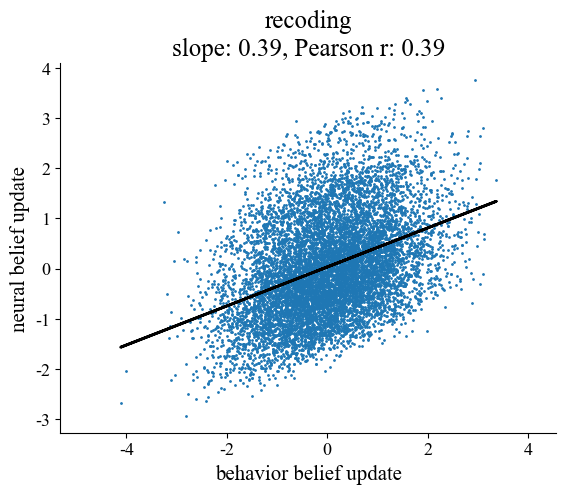

In [454]:

fig,ax=myscatter(dxs,dxs_hat)
plt.ylabel('neural belief update')
plt.xlabel('behavior belief update')
plt.title('recoding\n'+ax.get_title())
# ax.set_title(f'slope: {slope:.2f}, Pearson r: {r:.2f} \n encoding var explained {explained_variance_score(dxs,dxs_hat_pred) :.2f}')
plt.axis('equal')

In [455]:
# fit a recoding model
recode=LinearRegression()
recode.fit(us.reshape(-1,1), dxs_hat.reshape(-1,1))
print(recode.intercept_, recode.coef_, explained_variance_score(us.reshape(-1,1), dxs_hat.reshape(-1,1)))
thisx,thisy=us.reshape(-1), dxs_hat.reshape(-1)

# fig,ax=myscatter(thisx,thisy)
# plt.xlabel('obs')
# plt.ylabel('neural belief update')

[0.03480256] [[0.38852867]] -0.2197529557067699


In [456]:
# fig,ax=myscatter(us,dxs)
# plt.xlabel('obs')
# plt.ylabel('behavior belief update')

In [457]:
# total data variance: of blief update
totaldeltavar=np.var(dxs)
totaldeltavar

1.009079572336558

In [458]:
# total data variance: of neural update
totaneuralldeltavar=np.var(dxs_hat)
totaneuralldeltavar

1.0058609045060083

In [459]:
# # residual between neural update vs neural update pred from delta neural activity+encoding
# # neural update
# # neural update pred from delta neural activity (encoding)
# pred_dxs=encode.predict(drs.reshape(-1,1)).reshape(-1)
# encoding_residual_var=np.sum(np.array([(p-t)**2 for p, t in zip(dxs_hat,pred_dxs)]))/totaltime/triallen
# encoding_residual_var

In [460]:
# residual between neural update vs neural update pred from neural activity dynamic+recoding
# neural update
# neural update pred from neural dynamic model (recoding)
pred_dxs_hat=recode.predict(us.reshape(-1,1)).reshape(-1)
recoding_residual_var=np.sum(np.array([(p-t)**2 for p, t in zip(dxs_hat,pred_dxs_hat)]))/totaltime/triallen
recoding_residual_var

0.8535357754700784

In [461]:
# residual between neural update and behavior update
encoding_residual_var=np.sum(np.array([(p-t)**2 for p, t in zip(dxs_hat,dxs)]))/totaltime/triallen
encoding_residual_var

1.2317345932359955